In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import pandas as pd
from fitz import Rect

import numpy as np


from pdf_scraper.doc_utils import open_exam, get_images
from pdf_scraper.doc_utils import get_doc_line_df
from pdf_scraper.doc_utils import get_captions
from pdf_scraper.block_utils import clean_blocks
from pdf_scraper.line_utils  import print_line_table, get_line_df
from pdf_scraper.image_utils import filter_horizontal_strips, filter_point_images
from pdf_scraper.image_utils import get_stripped_images, stitch_strips, reconstitute_strips
from pdf_scraper.image_utils import get_in_image_captions

from pdf_scraper.doc_utils import filter_images

from pdf_scraper.line_utils import closest_image,closest_line, closest_vertical_line
from pdf_scraper.general_utils import bbox_vert_dist, bbox_distance
from pdf_scraper.general_utils import bbox_horiz_dist, shared_centre

In [65]:
from PIL import Image
from io import BytesIO

def show_image(image):
    img_bytes = image["image"]
    img_stream = BytesIO(img_bytes)
    img = Image.open(img_stream)
    display(img)

1. Get all images.
   - filter image artifacts and stitch stripped images. 
2. Get all text lines.
3. Identify and Remove captions from text lines.
4. Identify and resort dual column text.
5. Identify and remove page headers and footers. 

In [ ]:
# 2001 - good
# 2002 - non-caption close to image counted as caption. ==> to count as inside we say it must be > 0.2 inside.
# 2003 - good
# 2004 - good
# 2005 - 2 captions, captured but pictures are not all together, they are partitioned in boxes.
# 2006 - good -> point artifacts filtered
# 2007 - good
# 2008 - good
# 2009 - good
# 2010 - good
# 2011 - Captions below images page 2 and 3.
# 2012 - Mostly good, then some captions below image.
# 2013 - p2 img cut into slices; page 4 caption below image.
# 2014 - caption below image page 3. all others good
# 2015 - 2018 good
# 2019 - caption not contained in photo. (page 6)
# 2020 - good
# 2022 - good
# 2023 - good
# 2024 - good (no captions)
# 2025 - good (1 in image page 2)
# For caption prediction, we should have distance to nearest image
# distance to nearest text.
year=2014
doc = open_exam(year,"english","al",1)
doc_df = get_doc_line_df(doc)
images = get_images(doc)
print(f"number of raw images               : {len(images):10}")
images = filter_images(images)
print(f"number of images after filter: {len(images):10}")
images = get_captions(page_df, images)

number of raw images               :          8
number of images after filter:          8
                    text  page
132  source: amazon.com      3
133   Source:amazon.com      3
                      text  page
189  source:wordpress.com      4
                      text  page
260  source:pinterest.com      5
                    text  page
347  source: flickr.com      6
                  text  page
424  source: redfm.ie      7


In [ ]:
from pdf_scraper.line_utils import get_all_lines, is_empty_line
lines = get_all_lines(doc[3].get_text("dict",sort=True)["blocks"])
lins = [line for line in lines if not is_empty_line(line)]

{'spans': [{'size': 4.019999980926514,
   'flags': 20,
   'bidi': 0,
   'char_flags': 16,
   'font': 'TimesNewRomanPS-BoldMT',
   'color': 0,
   'alpha': 255,
   'ascender': 0.890999972820282,
   'descender': -0.2160000056028366,
   'text': ' ',
   'origin': (306.7200012207031, 53.459716796875),
   'bbox': (306.7200012207031,
    49.87789535522461,
    307.7250061035156,
    54.32803726196289)}],
 'wmode': 0,
 'dir': (1.0, 0.0),
 'bbox': (306.7200012207031,
  49.87789535522461,
  307.7250061035156,
  54.32803726196289)}

In [ ]:
page_6 = doc_df[doc_df.page==6]
median_size = page_6.font_size.median()
mode_font = page_6.common_font.mode().values[0]
print(f"median font size: {median_size}\nmedian font: {mode_font}")
img_bbox = image["bbox"]
page_6[page_6.font_size!=median_size ].head(30)


median font size: 12.0
median font: Calibri


,x0,y0,x1,y1,dL,n_spans,font_list,common_font,mode_font,n_words,w,h,text,font_sizes,font_size,page,dual_col
276,135.240005,65.984695,456.681274,82.004692,221.475021,1,[Calibri-Bold],Calibri-Bold,Calibri-Bold,7,321.441269,16.019997,TEXT 3 – LIBRARIES: CATHEDRALS OF OUR SOULS,[16.020000457763672],16.02,6,0
289,370.679993,287.459717,464.241486,299.459717,-192.960022,2,"[Calibri-Bold, Calibri-Bold]",Calibri-Bold,Calibri-Bold,2,93.561493,12.000000,Warstones Library,"[12.0, 10.979999542236328]",10.98,6,0
349,42.540001,795.944702,195.861481,806.924683,0.000000,2,"[Calibri-Italic, Calibri]",Calibri,Calibri-Italic,4,153.321480,10.979980,Leaving Certificate Examination 2019,"[10.020000457763672, 10.979999542236328]",10.02,6,0
350,294.899994,795.944702,302.961517,806.924683,13.140015,1,[Calibri],Calibri,Calibri,1,8.061523,10.979980,6,[10.979999542236328],10.98,6,0
351,42.540001,809.084717,173.382172,819.104736,NaN,1,[Calibri-Italic],Calibri-Italic,Calibri-Italic,5,130.842171,10.020020,English – Higher Level – Paper 1,[10.020000457763672],10.02,6,0


In [80]:
def closest_line_closest_thing(image,doc_df):
    n_page   = image["page"]
    img_bbox = image["bbox"]
    page_df = doc_df[doc_df.page==image["page"]].copy()
    overlap = page_df.apply(
        lambda row: bbox_horiz_dist((row["x0"],row["y0"],row["x1"],row["y1"] ),image["bbox"])==0,
        axis=1
        )
    centred = page_df.apply(
        lambda row: shared_centre( (row["x0"],row["y0"],row["x1"],row["y1"] ),image["bbox"]) ,
        axis=1
    )
    overlap_df = page_df[overlap & centred]
    idx, dist = closest_vertical_line(img_bbox, overlap_df, n_page)
    line_bbox = tuple(overlap_df.loc[idx][["x0","y0","x1","y1"]])

    idx1, dist1 = closest_vertical_line(line_bbox, overlap_df, n_page)
    line1_bbox  = tuple(overlap_df.loc[idx1][["x0","y0","x1","y1"]])

    if dist < dist1:
        print("The line which is closest to this image is closer to the image than it's nearest line.")
        return idx
    return None

In [93]:
img["page"]

3

In [94]:
#show_image(imgs_of_interest[0])
img = imgs_of_interest[0]
idx = closest_line_closest_thing(img,doc_df)
from pdf_scraper.draw_utils import draw_rectangle_on_page
from fitz import Rect
bbox = Rect(tuple(doc_df.loc[idx][["x0","y0","x1","y1"]]))
path = str(doc).split("'")[1]
draw_rectangle_on_page(path, "out.pdf", img["page"]-1, bbox)

The line which is closest to this image is closer to the image than it's nearest line.


In [103]:
doc_df.loc[idx].text

'collector’s\xa0item,\xa0or\xa0a\xa0rich\xa0man’s\xa0trophy.\xa0\xa0Yes,\xa0art\xa0'

The line which is closest to this image is closer to the image than it's nearest line.
Caption! for image on page 3


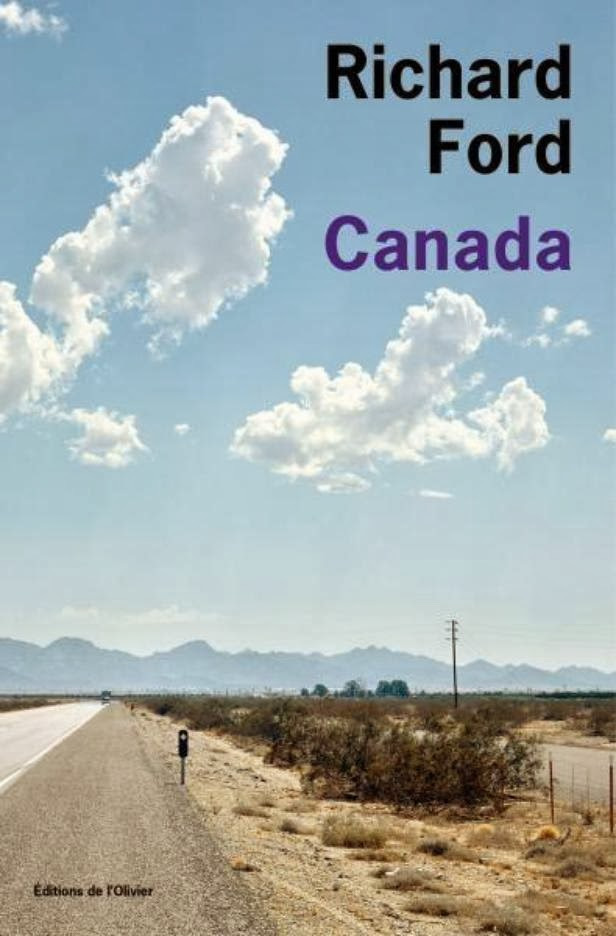

collector’s item, or a rich man’s trophy.  Yes, art  




ValueError: attempt to get argmin of an empty sequence

In [81]:
imgs_of_interest=[img for img in images if (img["page"]!=1 and img["page"]<9) ]
for img in imgs_of_interest:
    idx = closest_line_closest_thing(img,doc_df)
    if idx:
        print(f"Caption! for image on page {img["page"]}")
        show_image(img)
        print(doc_df.loc[idx].text,"\n\n")

In [ ]:
img2 = [img for img in images if img["page"]==2][0]
idx, dist  = closest_line(img2["bbox"], page_df, 2)
print(f"Closest line:\n{page_df.loc[idx].text}")
line_bbox = tuple(page_df.loc[idx][["x0","y0","x1","y1"]])
idx1, dist1 = closest_line(line_bbox, page_df, 2)
line1_bbox  = tuple(page_df.loc[idx1][["x0","y0","x1","y1"]])
print(f"Closest line to line:\n{page_df.loc[idx1].text}\n\n")
print(dist,dist1)


Closest line:
Art’s counter‐culture, however diverse, holds 
Closest line to line:
pay for it.  Art is being treated as a commodity.  


8.219696044921875 27.829254150390625


# Must examine bbox distance in line_utils. Somethin' ain't right. 

In [ ]:
page_df.loc[[idx,idx+2,idx1,]]

,x0,y0,x1,y1,dL,n_spans,font_list,common_font,mode_font,n_words,w,h,text,font_sizes,font_size,page,dual_col
41,310.200012,344.879700,533.412048,356.879700,14.640015,1,[Calibri],Calibri,Calibri,7,223.212036,12.0,"Art’s counter‐culture, however diverse, holds",[12.0],12.0,2,0
43,310.200012,359.519714,538.812073,371.519714,14.639984,1,[Calibri],Calibri,Calibri,8,228.612061,12.0,in plain sight what the material world denies –,[12.0],12.0,2,0
42,47.939999,347.339691,282.370758,359.339691,14.640015,1,[Calibri],Calibri,Calibri,10,234.430759,12.0,pay for it. Art is being treated as a commodi...,[12.0],12.0,2,0


- If there is a line which is nearer to the image than any other line.
- If the line is below or above and centred on the image centre.
- If the line has either a font or a font size which are not the median for that page. 

In [ ]:
idx, dist = closest_line(pg4_img_bbox, page_df, 4)
line_bbox = page_df.loc[idx][["x0","y0","x1","y1"]]
idx2, dist2 = closest_line(line_bbox, page_df, 4)
print(dist, dist2)
page_df.loc[[idx,idx2]]

12.0477294921875 7.8359375


<string>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


,x0,y0,x1,y1,dL,n_spans,font_list,common_font,mode_font,n_words,w,h,text,font_sizes,font_size,page,dual_col
201,399.600006,497.087708,478.274323,510.371704,-435.300034,1,[TimesNewRomanPS-BoldItal],TimesNewRomanPS-BoldItal,TimesNewRomanPS-BoldItal,2,78.674316,13.283997,William Trevor,[12.0],12.0,4,0
204,322.019989,518.207642,558.919250,531.491638,13.799927,1,[TimesNewRomanPS-ItalicMT],TimesNewRomanPS-ItalicMT,TimesNewRomanPS-ItalicMT,11,236.899261,13.283997,"You’ve said that when you start a story, it of...",[12.0],12.0,4,0


In [87]:
497.087708 - 518.207642

-21.119933999999944

In [ ]:
display(tuple(page_df.loc[idx][["x0","y0","x1","y1"]]))
display(page_df.loc[idx][["x0","y0","x1","y1"]])

(np.float64(399.6000061035156),
 np.float64(497.08770751953125),
 np.float64(478.2743225097656),
 np.float64(510.3717041015625))

x0    399.600006
y0    497.087708
x1    478.274323
y1    510.371704
Name: 201, dtype: object

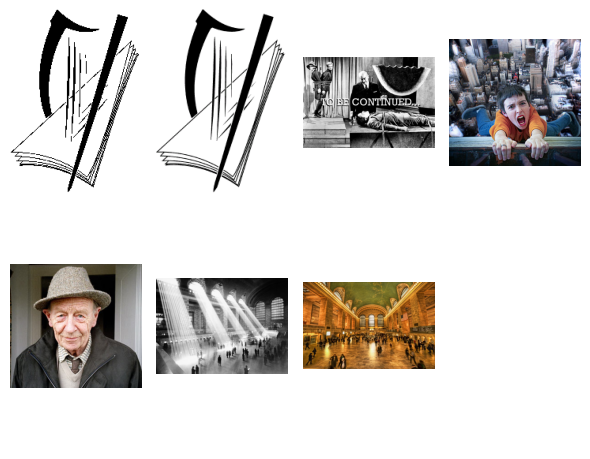

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
import io

# Assuming: images is a list of dicts, each with an "image" key containing bytes
fig, axes = plt.subplots(2, 4, figsize=(6, 5))  # 8x8 grid

for i, ax in enumerate(axes.flat):
    if i < len(images):  # Only show the available images
        img_bytes = images[i]["image"]
        img = Image.open(io.BytesIO(img_bytes))
        ax.imshow(img)
        ax.axis('off')
    else:
        ax.axis('off')  # Hide empty subplot

plt.tight_layout()
plt.show()

In [47]:
type(dists.idxmin())

numpy.int64

In [ ]:
def bbox_distance(bbox1, bbox2):
    """
    Calculates the minimum edge-to-edge distance between two bounding boxes.
    Each box is in [x_min, y_min, x_max, y_max] format.
    Returns 0 if they overlap or touch.
    """
    x_min1, y_min1, x_max1, y_max1 = bbox1
    x_min2, y_min2, x_max2, y_max2 = bbox2

    dx = max(x_min2 - x_max1, x_min1 - x_max2, 0)
    dy = max(y_min2 - y_max1, y_min1 - y_max2, 0)

    return np.hypot(dx, dy)


In [ ]:
page_df.loc[201].text

'William Trevor '

In [ ]:
dists=page_df[page_df.page == 4].apply(
    lambda row: bbox_distance((row["x0"], row["y0"], row["x1"], row["y1"]), pg4_img_bbox),
    axis=1
    )
dists.min()
dists.idxmin()

np.int64(201)

In [ ]:
print(dists.sort_values())
print(dists.idxmin())


201     12.047729
185     18.708282
192     28.456970
190     28.586609
199     28.586792
          ...    
239    290.687683
238    290.956051
241    304.487732
240    304.695866
242    389.909231
Length: 82, dtype: float64
201


In [ ]:
def bbox_distance(bbox1, bbox2):
    """
    Calculates the minimum edge-to-edge distance between two bounding boxes.
    Each box is in [x_min, y_min, x_max, y_max] format.
    Returns 0 if they overlap or touch.
    """
    x_min1, y_min1, x_max1, y_max1 = bbox1
    x_min2, y_min2, x_max2, y_max2 = bbox2

    dx = max(x_min2 - x_max1, x_min1 - x_max2, 0)
    dy = max(y_min2 - y_max1, y_min1 - y_max2, 0)

    return np.hypot(dx, dy)

page_df[page_df.page==4][["x0","y0","x1","y1"]].map(x: bbox_distance((x["x0"],x["y0"],x["x1"],x["y1"]),bbox))
mask =

overlap_mask = (
    (page_df["x1"] > img_rect.x0 + 0.2) &
    (page_df["x0"] < img_rect.x1) &
    (page_df["y1"] > img_rect.y0 + 0.2) &
    (page_df["y0"] < img_rect.y1) &
    (page_df["page"] == image["page"] )
)
overlapping_rows = page_df[overlap_mask]

,x0,y0,x1,y1
161,275.040009,29.801722,346.554047,49.727722
162,56.700001,61.787674,554.339966,75.071678
163,56.700001,75.587723,301.019989,88.871727
164,56.700001,103.127701,255.040771,116.411705
165,322.019989,104.207718,558.940796,117.491722
...,...,...,...,...
238,56.700001,774.587708,299.408417,787.871704
239,322.019989,775.727661,558.921387,789.011658
240,56.700001,788.387695,299.370026,801.671692
241,322.019989,789.527710,432.650482,802.811707


In [6]:
page_2_strips = [image for image in images if image["page"]==2  ]
print(len(page_2_strips))
heights=[strip["height"] for strip in page_2_strips ]
widths =[strip["width"] for strip in page_2_strips ]
display(np.unique(heights))
display(np.unique(widths))

254


array([1])

array([367])

In [ ]:
# As a reasonable width we would want it to be around an 1/8th of the page, or perhaps
# at least as wide as the harp that appears on all the exams.
doc[1].get_text("dict")["width"]/8
def is_horizontal_strip(img):
    return img["height"] <2 and img["width"] > 40

all([is_horizontal_strip(img) for img in page_2_strips] )

True

In [30]:
y0s = [img["bbox"][1] for img in page_2_strips]

for i in range(len(y0s[:-2]) ):
    if y0s[i+1] < y0s[i]:
        print("not monotonic!")

# label dual column text

## Label page 2

In [16]:
grand_df[grand_df.page==2].text.head(15)

24    SECTION I                       COMPREHENDING ...
25                        TEXT 1 – FROM GENRE to GENRE 
26    This text consists of two elements: firstly, e...
27    The Misadventures of a Dithering Writer in Thi...
28    writing in different genres.  The second eleme...
29    I flit anxiously and eagerly from genre to gen...
30    yourself be led by the child that you were.  T...
31     I always have a few stories on the go.  Some of 
32       is a tendency I adhered to upon my resumption 
33     and, indeed, return to when it all threatens to 
34     them are like eels – they slip away if I do not 
35    make a fast grab.  Some are like bold children – 
36                                   get away from me. 
37      they pay absolutely no attention to anything I 
38     tell them to do.  One or two arrive unannounced 
Name: text, dtype: object

function
- takes in 4 lines: top left, top right, bottom left, bottom right
- makes copy of data frame
- identifies all lines between these. (max and min index)
- sorts this part of the data frame 
- returns tuple (sorted data frame, indices)

Then you can reassign this sorted data frame to the original data frame between
the provided indices.

Or else it can change the passed data frame in place which would be as useufl. 

In [17]:
def setDualCols(grand_df: pd.DataFrame, page_num:int, bookends: tuple[str]):
    page_df = grand_df[grand_df.page==page_num].copy()
    l1, r1, l2, r2 = bookends
    for line in bookends:
        print(page_df[page_df.text.str.contains(line)].index)
    indices = [page_df[page_df.text.str.contains(line)].index for line in bookends]
    top    = min(indices).values[0]
    bottom = max(indices).values[0]
    dual_cols = page_df[top:bottom+1].copy()
    dual_cols.sort_values(["x0","y0"],inplace=True)
    dual_cols["daul_col"]=1

    grand_df.loc[top:bottom+1] = dual_cols

    return grand_df


In [18]:
grand_df[grand_df.page==2].text.head(40)

24    SECTION I                       COMPREHENDING ...
25                        TEXT 1 – FROM GENRE to GENRE 
26    This text consists of two elements: firstly, e...
27    The Misadventures of a Dithering Writer in Thi...
28    writing in different genres.  The second eleme...
29    I flit anxiously and eagerly from genre to gen...
30    yourself be led by the child that you were.  T...
31     I always have a few stories on the go.  Some of 
32       is a tendency I adhered to upon my resumption 
33     and, indeed, return to when it all threatens to 
34     them are like eels – they slip away if I do not 
35    make a fast grab.  Some are like bold children – 
36                                   get away from me. 
37      they pay absolutely no attention to anything I 
38     tell them to do.  One or two arrive unannounced 
39      I am, at various times, a reluctant, plodding, 
40    instinctive, spontaneous writer.  At times I f...
41        from the farthest recesses of my imagi

In [19]:
line_l1 = "I flit anxious"
line_r1 = "yourself be led by the child"
line_lf = "imagination had not abandoned me"
line_rf = "lose almost all the time"

bookends = [line_l1,line_r1, line_lf, line_rf]

grand_df = setDualCols(grand_df, 2, bookends)

Index([29], dtype='int64')
Index([30], dtype='int64')
Index([106], dtype='int64')
Index([107], dtype='int64')


In [20]:
grand_df[grand_df.page==2].text.head(40)

24    SECTION I                       COMPREHENDING ...
25                        TEXT 1 – FROM GENRE to GENRE 
26    This text consists of two elements: firstly, e...
27    The Misadventures of a Dithering Writer in Thi...
28    writing in different genres.  The second eleme...
53                              immediate attention.   
54             I don’t know if my writing is in anyway 
55        I have started several novels.  There is the 
56    distinctive.  I am an aural learner as opposed...
57       edgy-existential one about the brother-sister 
58        assassination squad.  There is the comedy-of-
59            say the more common visual learning that 
60         attends so much writing.  I can hear things 
61      desperation one about the office slave finally 
62           tipped over the edge by a boss constantly 
63      before I see them.  My reasons for writing are 
64    partly intrinsic, partly spiritual, partly fan...
65       referred to as the highly evolved veget

In [75]:
page2_df = grand_df[grand_df.page==2].copy()
line_l1 = "I flit anxious"
line_r1 = "yourself be led by the child"

line_lf = "imagination had not abandoned me"
line_rf = "lose almost all the time"

bookends = [line_l1,line_r1, line_lf, line_rf]
for line in bookends:
    print(page2_df[page2_df.text.str.contains(line)].index)
indices = [page2_df[page2_df.text.str.contains(line)].index for line in bookends]
top = min(indices)
bottom = max(indices)

Index([29], dtype='int64')
Index([69], dtype='int64')
Index([68], dtype='int64')
Index([107], dtype='int64')


In [73]:
page2_text = page2_df[top.values[0]:bottom.values[0]+1].sort_values(["x0","y0"])
page2_text["dual_col"]=1

# Fixing stripped images

We were workin gthrough these functions from chat gpt:

In [ ]:
year=2013
doc = open_exam(year,"english","al",1)
page_df = get_doc_line_df(doc)
images = get_images(doc)
print(f"number of raw images                : {len(images):10}")
images = filter_point_images(images)
print(f"number of images after  point filter: {len(images):10}")
images = get_captions(page_df, images)

number of raw images                :        260
number of images after  point filter:        260
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
         text  page
133  IMAGE 2      3


In [8]:
x0s = np.unique([strip["bbox"][0] for strip in page_2_strips])
n_strip_images = len(x0s)
for x0 in x0s:
    print(x0)
    strips = [strip for strip in page_2_strips if strip["bbox"][0]==x0]
len(strips)

343.44000244140625


254

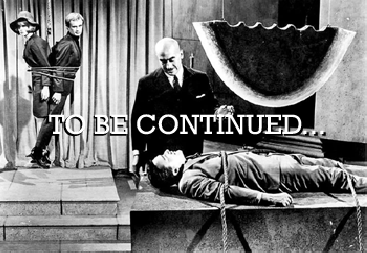

In [21]:
sticthed_image = stitch_strips(page_2_strips)
show_image(sticthed_image)
#sticthed_image

In [24]:
# Manually assigning captions

In [ ]:
display(page_df[page_df.text=='Warstones\xa0Library\xa0'][["x0","y0","x1","y1"]])

bbox = tuple(page_df[page_df.text=='Warstones\xa0Library\xa0'][["x0","y0","x1","y1"]].values[0])
img = closest_image(bbox,images)
img["caption"]='Warstones\xa0Library\xa0'